### Carregando dataset

In [1]:
from urllib.request import urlopen, urlretrieve
import os

urls = {
    'ssvep': 'https://archive.ics.uci.edu/ml/machine-learning-databases/00457/BCI-SSVEP_Database_Aceves.zip'
}

# verifica se o diretório dos datasets existe
if not os.path.exists('dataset_ssvep/'):
    os.mkdir('dataset_ssvep/')
    for k, v in urls.items():
        fn = v.split('/')[-1]
        print('Baixando:', fn, '...')
        urlretrieve(v, './dataset_ssvep/{}'.format(fn))
    print('Downlod do dataset concluído!')
else:
    print('Dataset já baixado!')

Baixando: BCI-SSVEP_Database_Aceves.zip ...
Downlod do dataset concluído!


In [2]:
import zipfile
import os

if not os.path.exists('dataset_ssvep/BCI-SSVEP_Database_Aceves/'):
    zip_ref = zipfile.ZipFile('dataset_ssvep/BCI-SSVEP_Database_Aceves.zip', 'r')
    zip_ref.extractall('dataset_ssvep/BCI-SSVEP_Database_Aceves/')
    zip_ref.close()
    print('Descompactação finalizada!')
else:
    print('Descompactação já realizada anteriormente!')

Descompactação finalizada!


### Carregando dados de um arquivo do dataset

In [3]:
import numpy as np
import pandas as pd
import csv

def load_data(ssvep_file): #ssvep_file = .csv   
    with open(ssvep_file, newline='') as csvfile:
        readCSV = csv.reader(csvfile, quotechar='|')
        trials = list() #nao sei se to usando certo esses nomes (trials, chs e values)
        chs = list()
        values = list()
        teste = list()
        begin = 0
        for row in readCSV:
            if row[0] == '0': #controle para não pegar os primeiros dados que começam errado
                begin = 1
            if begin == 1:
                for i in range (2, 16):
                    values.append(float(row[i]))
                chs.append(values)
                values = list()
                if row[0] == '128':
                    trials.append(chs)
                    chs = list()
        for input in trials: #inverter shape. (de (21,129,14) para (21,14,129))
            df = pd.DataFrame(input).T
            output = [[element for element in row if not np.isnan(element)] for row in df.values]
            teste.append(output)
            
            
        data = np.array(teste)
        return data



### exibindo ....

In [4]:
data = load_data('dataset_ssvep/BCI-SSVEP_Database_Aceves/A001SB1_1.csv')
print('SSVEP file shape: ', data.shape) #pelo shape deve estar certo...

SSVEP file shape:  (21, 14, 129)


### plotando os graficos

(14, 129)
Creating RawArray with float64 data, n_channels=14, n_times=129
    Range : 0 ... 128 =      0.000 ...     0.992 secs
Ready.
Effective window size : 1.000 (s)


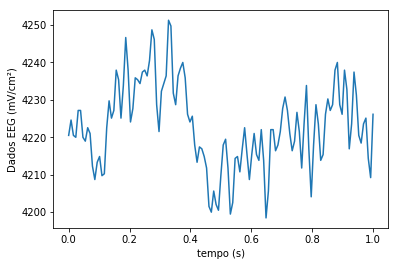

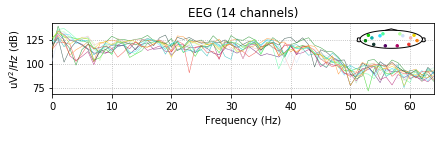

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne

x = data[0]
print(x.shape)

ch_names = ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
ch_types = ['eeg'] * 14
info = mne.create_info(ch_names=ch_names, sfreq=129, ch_types=ch_types)
raw = mne.io.RawArray(x, info)

# São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
#raw.drop_channels(['x', 'nd', 'y'])

# Aplicamos a montagem do padrão 10-20 para todos os eletrodos
# 
montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage)

# Neste primeiro gráfico mostramos o sinal de um eletrodo no domínio do tempo
plt.plot(np.linspace(0, 1, 129), raw.get_data()[0])
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

# Aqui mostramos todos os 61 eletrodos que representam dados EEG
raw.plot_psd()
print()

### Aplicando filtro temporal

In [82]:
#DAQUI PRA BAIXO NÃO MECHEMOS AINDA(CÓPIA DO PRE-PROCESSING DO PROFESSSOR)
from copy import deepcopy

raw2 = deepcopy(raw)
raw2.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
raw2.filter(5., 50., fir_design='firwin')
raw2.plot_psd(area_mode='range')
print()

raw3 = deepcopy(raw)
raw3.notch_filter(np.arange(60, 121, 60), fir_design='firwin', trans_bandwidth=6.7, filter_length='996ms')
raw3.filter(5., 50., fir_design='firwin', l_trans_bandwidth=3.35, filter_length='996ms')
raw3.plot_psd(area_mode='range')

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(0, 1, 256), raw.get_data()[0])
plt.title('Não filtrado')
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(0, 1, 256), raw3.get_data()[0])
plt.title('Filtrado')
plt.xlabel('tempo (s)')
print()

ValueError: h_freq ([ 59.35 119.2 ]) must be less than the Nyquist frequency 64.5

### Aplicando filtro espacial

In [83]:
from sklearn.decomposition import PCA
from mne import set_eeg_reference as car

pca = PCA(n_components=1)
projected = pca.fit_transform(raw3.get_data().T).T
print(projected.shape)

info = mne.create_info(ch_names=('x',), sfreq=256)
new_raw = mne.io.RawArray(projected, info)

plt.plot(np.linspace(0, 1, 256), new_raw.get_data()[0])
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

chs_P = [c for c in raw.ch_names if c[0] == 'p']
print(chs_P)

inst, data = car(raw, ref_channels=chs_P)
print(data.shape)
print(inst)
plt.plot(np.linspace(0, 1, 256), data)
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

NameError: name 'raw3' is not defined